<a href="https://colab.research.google.com/github/Ash-git-create/Data_Analytics_1_WiSe2024/blob/main/Day_8_Excercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import shap
from sklearn.ensemble import IsolationForest

data = pd.read_csv(io.BytesIO(uploaded['train.csv']))
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [ ]:
print(f"Missing values: {data.isnull().sum().sum()}")
data = data.dropna()

Missing values: 0


Shape after outlier removal: (20199, 82)
Selected features: Index(['mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass',
       'wtd_gmean_atomic_mass', 'range_fie', 'std_fie',
       'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius',
       'range_ElectronAffinity', 'std_ElectronAffinity'],
      dtype='object')
Linear Regression - R2: 0.58, RMSE: 22.31
Cross-Validation R2 Scores: [0.5798631  0.587157   0.5683062  0.57495797 0.5801522 ]
Mean CV R2 Score: 0.58
Ridge Regression - R2: 0.58, RMSE: 22.32


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+03, tolerance: 1.914e+03
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - R2: 0.58, RMSE: 22.33
Polynomial Regression - R2: 0.68, RMSE: 19.38


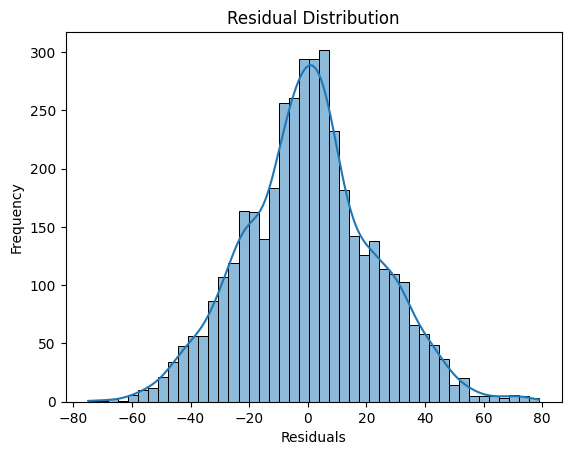

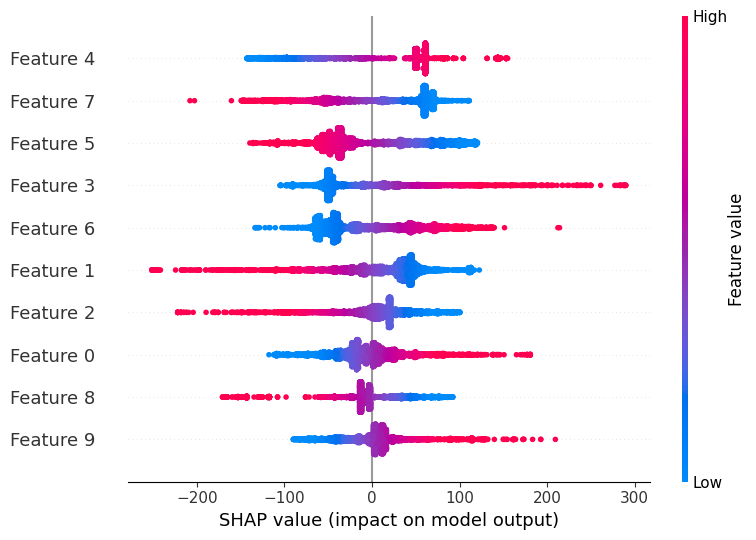

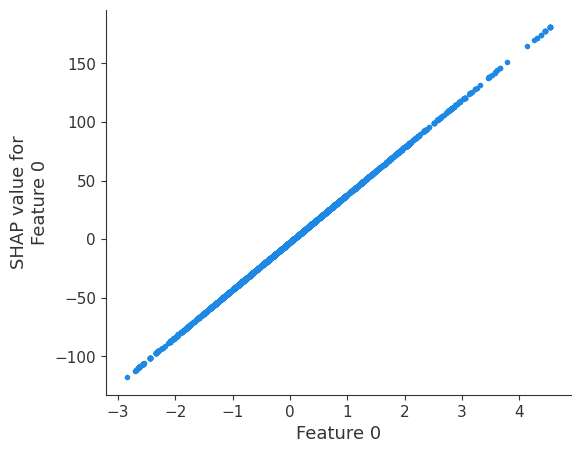

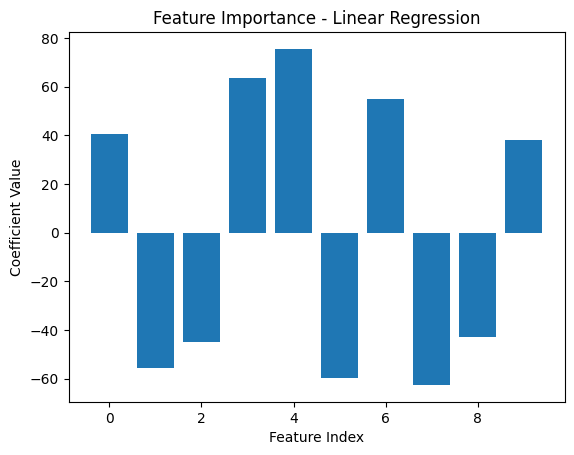

Best Ridge Alpha: 0.1


In [ ]:
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso.fit_predict(data)
data = data[outlier_preds == 1]
print(f"Shape after outlier removal: {data.shape}")

## Feature scaling
X = data.drop("critical_temp", axis=1)
y = data["critical_temp"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Feature selection using Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_selected = rfe.fit_transform(X_scaled, y)
selected_features = X.columns[rfe.support_]
print(f"Selected features: {selected_features}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Build and evaluate models
## Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation metrics
lr_r2 = r2_score(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression - R2: {lr_r2:.2f}, RMSE: {lr_rmse:.2f}")

## K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X_selected, y, cv=kf, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores):.2f}")

# Enhance the model
## Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_y_pred = ridge.predict(X_test)

ridge_r2 = r2_score(y_test, ridge_y_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
print(f"Ridge Regression - R2: {ridge_r2:.2f}, RMSE: {ridge_rmse:.2f}")

## Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
lasso_y_pred = lasso.predict(X_test)

lasso_r2 = r2_score(y_test, lasso_y_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_y_pred))
print(f"Lasso Regression - R2: {lasso_r2:.2f}, RMSE: {lasso_rmse:.2f}")

## Polynomial Regression
poly = PolynomialFeatures(degree=2)
poly_model = make_pipeline(poly, LinearRegression())
poly_model.fit(X_train, y_train)
poly_y_pred = poly_model.predict(X_test)

poly_r2 = r2_score(y_test, poly_y_pred)
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_y_pred))
print(f"Polynomial Regression - R2: {poly_r2:.2f}, RMSE: {poly_rmse:.2f}")

# Visualizations
## Residual Plot
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

## SHAP Analysis
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)

shap_values_array = shap_values.values

shap.dependence_plot(0, shap_values_array, X_test, interaction_index=None)


## Feature Importance
plt.bar(range(len(lr.coef_)), lr.coef_)
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance - Linear Regression")
plt.show()

# Hyperparameter tuning for Ridge Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10]}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)
print(f"Best Ridge Alpha: {ridge_grid.best_params_['alpha']}")


# **Tree Models**

To perform these actions and to do evaluation, we need to convert the target variable (critical_temp) into a category variable. (We use binning here)

In [ ]:
# Binning the target variable
bins = [data['critical_temp'].min(), 50, 100, data['critical_temp'].max()]
labels = [0, 1, 2]  # Example: 0 for low, 1 for medium, 2 for high
data['temp_category'] = pd.cut(data['critical_temp'], bins=bins, labels=labels)

# Splitting features and target
X = data.drop(["critical_temp", "temp_category"], axis=1)
y = data['temp_category']

 # Impute with the most frequent value
if y.isnull().any():
    print("Null values found")
    y = y.fillna(y.mode()[0])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Null values found


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
dt_preds = dt.predict(X_test_scaled)

dt_accuracy = accuracy_score(y_test, dt_preds)
dt_precision = precision_score(y_test, dt_preds, average='weighted')
dt_recall = recall_score(y_test, dt_preds, average='weighted')
dt_f1 = f1_score(y_test, dt_preds, average='weighted')

print(f"Decision Tree - Accuracy: {dt_accuracy:.2f}, Precision: {dt_precision:.2f}, Recall: {dt_recall:.2f}, F1 Score: {dt_f1:.2f}")


Decision Tree - Accuracy: 0.92, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds, average='weighted')
rf_recall = recall_score(y_test, rf_preds, average='weighted')
rf_f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Random Forest - Accuracy: {rf_accuracy:.2f}, Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}, F1 Score: {rf_f1:.2f}")


Random Forest - Accuracy: 0.94, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


Gradient bossted trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
gb_preds = gb.predict(X_test_scaled)

gb_accuracy = accuracy_score(y_test, gb_preds)
gb_precision = precision_score(y_test, gb_preds, average='weighted')
gb_recall = recall_score(y_test, gb_preds, average='weighted')
gb_f1 = f1_score(y_test, gb_preds, average='weighted')

print(f"Gradient Boosted Trees - Accuracy: {gb_accuracy:.2f}, Precision: {gb_precision:.2f}, Recall: {gb_recall:.2f}, F1 Score: {gb_f1:.2f}")



Gradient Boosted Trees - Accuracy: 0.93, Precision: 0.93, Recall: 0.93, F1 Score: 0.93


K-Nearest Neighbours

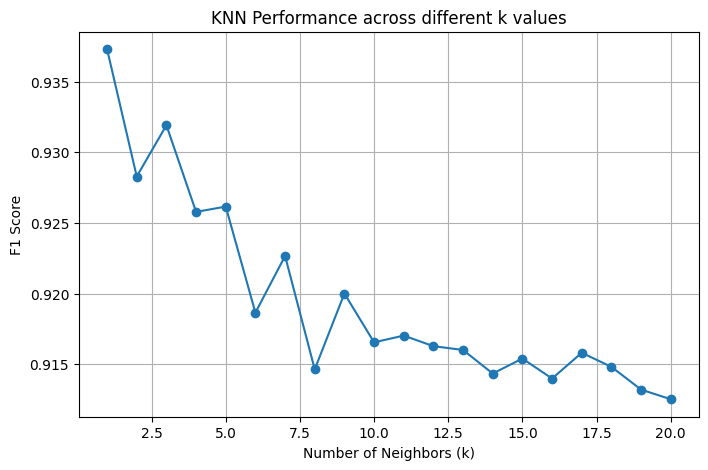

Optimal k for KNN: 1


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1, 21)
knn_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_preds = knn.predict(X_test_scaled)

    knn_f1 = f1_score(y_test, knn_preds, average='weighted')
    knn_scores.append(knn_f1)

# Plotting F1 scores against k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, knn_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("F1 Score")
plt.title("KNN Performance across different k values")
plt.grid()
plt.show()

# Best k
best_k = k_values[np.argmax(knn_scores)]
print(f"Optimal k for KNN: {best_k}")


Evaluation

In [ ]:
# Summarize results
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'KNN']
accuracies = [dt_accuracy, rf_accuracy, gb_accuracy, max(knn_scores)]
precisions = [dt_precision, rf_precision, gb_precision, None]  # KNN precision can also be calculated similarly.
recalls = [dt_recall, rf_recall, gb_recall, None]  # Same for recall.
f1_scores = [dt_f1, rf_f1, gb_f1, max(knn_scores)]

comparison = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print(comparison)

               Model  Accuracy  Precision    Recall  F1 Score
0      Decision Tree  0.923762   0.923222  0.923762  0.923458
1      Random Forest  0.944802   0.944948  0.944802  0.944856
2  Gradient Boosting  0.927970   0.929381  0.927970  0.928498
3                KNN  0.937295        NaN       NaN  0.937295
